In [2]:
import avocado
import matplotlib as mpl
# Choose how big to make figures. This will scale the text size.
mpl.rcParams['figure.figsize'] = (3, 3)

# Set the DPI. This will change how big things appear in Jupyter lab
mpl.rcParams['figure.dpi'] = 120

import itertools
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.stats import binned_statistic

In [2]:
dataset_name = 'plasticc_test_ddf_100'
print("Loading dataset...")
dataset = avocado.load(dataset_name, metadata_only=True, verify_input_chunks=False)

# In the PLAsTiCC test data, the class 99 objects are split out. Combine them back together.
dataset.metadata['raw_class'] = dataset.metadata['class']
dataset.metadata['class'] = np.clip(dataset.metadata['class'], None, 99)

# Setup the prediction arrays
predictions = []
kaggle_predictions = []
prediction_names = []
prediction_labels = []

print("Done!")

Loading dataset...
Done!


In [3]:
print("Loading predictions...")
avocado_predictions = {
    'flat_weight': 'Flat-weighted classifier',
#     'redshift_weight': 'Redshift-weighted classifier',

#     'flat_weight_bias_low': 'Flat-weighted, low-z bias',
#     'flat_weight_bias_high': 'Flat-weighted, high-z bias',

#     'redshift_weight_bias_low': 'Redshift-weighted, low-z bias',
#     'redshift_weight_bias_high': 'Redshift-weighted, high-z bias',
}

for prediction_name, prediction_label in avocado_predictions.items():
    print("    Loading %s..." % prediction_label)
    prediction = dataset.load_predictions(prediction_name)
    predictions.append(prediction)
    kaggle_predictions.append(avocado.plasticc.create_kaggle_predictions(dataset, prediction))
    prediction_names.append(prediction_name)
    prediction_labels.append(prediction_label)
    
print("Done!")

Loading predictions...
    Loading Flat-weighted classifier...
Done!


In [4]:
d_train = avocado.load('plasticc_augment_ddf_100', verify_input_chunks=False)

# Load the features if they have been computed.
try:
    d_train.load_raw_features()
    d_train.select_features(avocado.plasticc.PlasticcFeaturizer());
except avocado.AvocadoException:
    print("Training set features not available! Some functionality will be missing!")

In [5]:
flat_metric_scores = []

print("Flat metric:")
for prediction, prediction_label in zip(predictions, prediction_labels):
    scores = avocado.weighted_multi_logloss(
        dataset.metadata['class'],
        prediction,
        class_weights=avocado.plasticc.plasticc_flat_weights,
        return_object_contributions=True
    )
    print("%30s: %.5f" % (prediction_label, np.sum(scores)))
    flat_metric_scores.append(scores)

Flat metric:
      Flat-weighted classifier: 2.63906


In [6]:
plot_labels_short = {
    6: 'Single $\mu$-lens - 6',
    15: 'TDE - 15',
    16: 'Eclip. Binary - 16',
    42: 'SNII - 42',
    52: 'SNIax - 52',
    53: 'Mira - 53',
    62: 'SNIbc - 62',
    64: 'Kilonova - 64',
    65: 'M-dwarf - 65',
    67: 'SNIa-91bg - 67',
    88: 'AGN - 88',
    90: 'SNIa - 90',
    92: 'RR lyrae - 92',
    95: 'SLSN-I - 95',
    99: 'Unknown - 99',
}

In [25]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60, ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()
    
    # Make a colorbar that is lined up with the plot
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.25)
    plt.colorbar(im, cax=cax, label='Fraction of objects')


def do_confusion_matrix(index, show_title=True):
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(9,8))
    
    # Only include classes that we have predictions for
    true_classes = dataset.metadata['class']
    pred = predictions[index]
    
    mask = true_classes.isin(pred.columns)
    
    mask_classes = true_classes[mask]
    mask_pred = pred[mask]

    true_indices = np.argmax(pd.get_dummies(mask_classes).values, axis=1)
    pred_indices = np.argmax(mask_pred.values, axis=-1)
    
    if show_title:
        title = 'Confusion matrix - %s' % prediction_labels[index]
    else:
        title = ''
        
    cnf_matrix = confusion_matrix(true_indices, pred_indices)
    plot_confusion_matrix(
        cnf_matrix,
        classes=[plot_labels_short[i] for i in pred.columns],
        normalize=True,
        title=title,
    )

Normalized confusion matrix


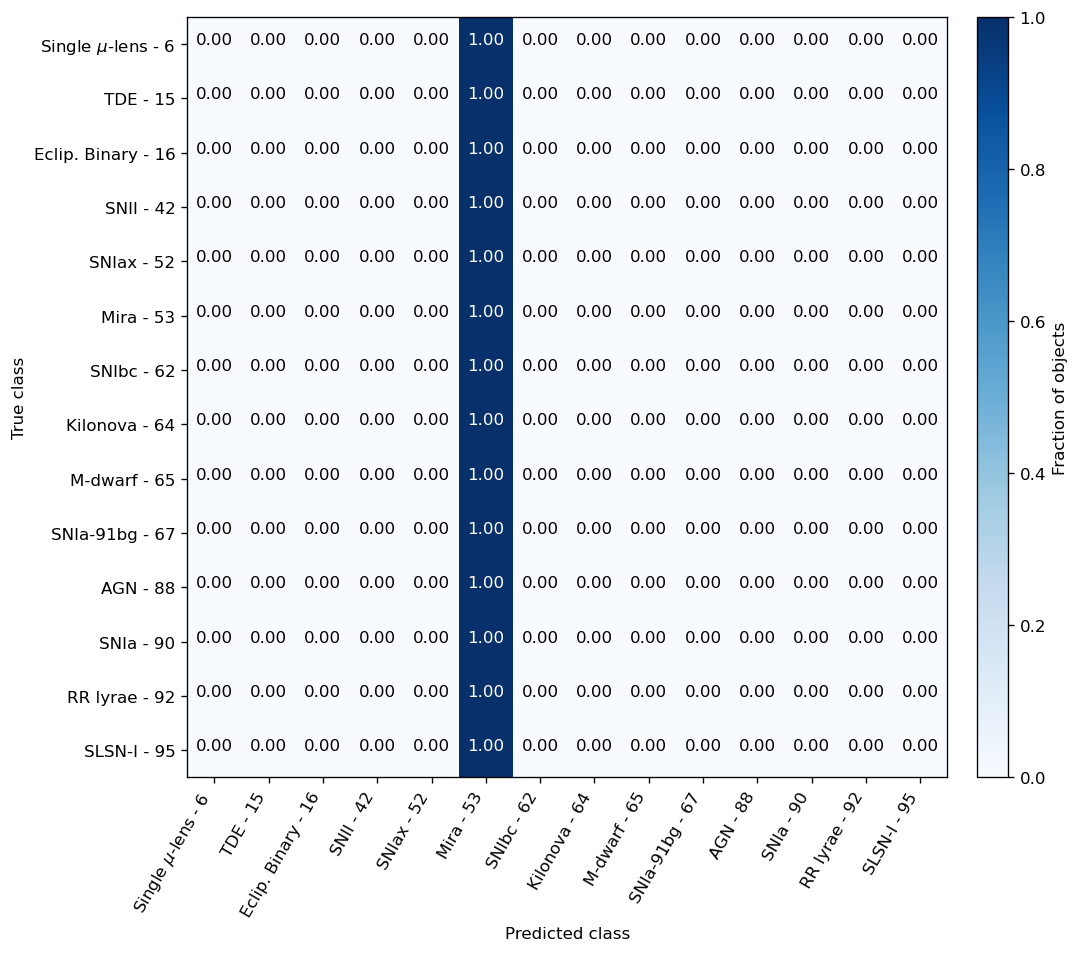

In [18]:
# Save the confusion matrix
selected_classifier = 'flat_weight'

index = prediction_names.index(selected_classifier)
do_confusion_matrix(index, show_title=False)

# Confusion matrix of our method

In [3]:
filename = os.path.join("..", "data", "results", "plasticc", "iter2_augment_ddf_100.csv")
df = pd.read_csv(filename)

In [4]:
df = df.sort_values("mean_cv", ascending=False)
df

,pivot_win,pivot_wl,wins,wls,dropped,mean_cv,std_cv,exp_var,n_comp,scheme
2,78.164126,5,78.164 610.963 62.199 78.164,5 3 3 4,0,0.477017,0.021493,NaN,579,ltc
0,62.199146,4,62.199 123.439 610.963 78.164,4 4 3 3,0,0.475672,0.039547,NaN,579,ltc
3,62.199146,5,62.199 123.439 62.199 610.963,5 4 4 2,0,0.473141,0.015298,NaN,579,ltc
4,98.226920,5,98.227 78.164 62.199 610.963,5 5 3 3,0,0.471639,0.024497,NaN,579,ltc
1,78.164126,4,78.164 610.963 78.164 307.855,4 3 2 2,0,0.461618,0.036036,NaN,579,ltc


In [5]:
wins = np.array(df.iloc[3].wins.split(), dtype=float)
wls = np.array(df.iloc[3].wls.split(), dtype=int)

In [7]:
wls, wins

(array([5, 5, 3, 3]), array([ 98.227,  78.164,  62.199, 610.963]))

In [8]:
import os
import sys
main_path = os.path.abspath(os.path.join(os.path.dirname("comparinson_100.ipynb"), ".."))
sys.path.insert(0, main_path)
from src.preprocesing import gen_dataset, gen_dataset_from_h5
from src.feature_extraction.text import ParameterSelector, MPTextGenerator, TextGeneration, CountVectorizer
from src.feature_extraction.vector_space_model import VSM
from src.feature_extraction.centroid import CentroidClass
from src.feature_selection.select_k_best import SelectKTop
from src.decomposition import LSA, PCA
from src.neighbors import KNeighborsClassifier
from src.feature_extraction.window_slider import TwoWaysSlider

from scipy import sparse
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, VarianceThreshold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [9]:
d_train, l_train, meta_train = gen_dataset_from_h5("plasticc_train")
classes = np.unique(l_train)
bands = ["lsstg", "lssti", "lsstr", "lsstu", "lssty", "lsstz"]
d_test, l_test, meta_test = gen_dataset_from_h5("plasticc_test_ddf_100")

Object: 100%|████████████████████████████████████████████████████████████████████| 944/944 [00:00<00:00, 322533.64it/s]


In [47]:
doc_kwargs = {
        "alphabet_size": np.array([3, 3]),
        "quantity": np.array(["mean", "trend"]),
        "irr_handler": "#",
        "mean_bp_dist": "normal",
        "verbose": True
    }
class_based = True  # options: True, False
normalize = 'l2'  # options: None, l2
use_idf = True  # options: True, False
sublinear_tf = True  # options: True, False

In [48]:
x = None
for win, wl in zip(wins, wls):
    text_gen = MPTextGenerator(win=win, wl=wl, direct_bow=True, bands=bands, **doc_kwargs)
    x_i = text_gen.transform(d_train)
    if x is None:
        x = x_i.copy()
    else:
        x = sparse.hstack((x, x_i), format="csr", dtype=x.dtype)
    break

In [45]:
alph_size = np.array([3, 3]).prod()
(alph_size + 1) ** 5

100000

In [49]:
x.shape

(7848, 600000)

In [ ]:
x_test = None
for win, wl in zip(wins, wls):
    text_gen = MPTextGenerator(win=win, wl=wl, direct_bow=True, bands=bands, **doc_kwargs)
    x_i = text_gen.transform(d_test)
    if x_test is None:
        x_test = x_i.copy()
    else:
        x_test = sparse.hstack((x_test, x_i), format="csr", dtype=x_test.dtype)
#     break

In [ ]:
x_test

In [12]:
%%time
vsm = VSM(class_based=False, classes=classes, norm=normalize, use_idf=use_idf,
              smooth_idf=True, sublinear_tf=sublinear_tf)
x2 = vsm.fit_transform(x, y=l_train)

Wall time: 7.81 ms


In [13]:
%%time
lsa = LSA(sc=580, algorithm="randomized", n_iter=20, random_state=None, tol=0.)
x3 = lsa.fit_transform(x2, y=l_train)
print(x2.shape, x3.shape)

(7848, 18750) (7848, 579)
Wall time: 17.3 s


In [14]:
%%time
normalizer = Normalizer()
x32 = normalizer.fit_transform(x3)

Wall time: 30.2 ms


In [15]:
%%time
centroid = CentroidClass(classes=classes)
x4 = centroid.fit_transform(x3, y=l_train)
print(x4.shape)

(14, 579)
Wall time: 5.51 s


In [16]:
%%time
knn = KNeighborsClassifier(n_neighbors=1, classes=classes, useClasses=class_based)
knn.fit(x4, classes)

Wall time: 975 µs


KNeighborsClassifier(classes=array([ 6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]),
                     useClasses=True)

In [29]:
%%time
x2_ = vsm.transform(x_test)
x3_ = lsa.transform(x2_)
x4_ = normalizer.transform(x3_)
print((x3_ == x4_).all())
l_pred = knn.predict(x4_)
print(balanced_accuracy_score(l_test, l_pred))
print(knn.score(x4_, l_test))

False
0.34422219004697896
0.2891949152542373
Wall time: 94.7 ms


In [50]:
vsm_ = VSM(class_based=False, classes=classes, norm=normalize, use_idf=use_idf,
              smooth_idf=True, sublinear_tf=sublinear_tf)
lsa_ = LSA(sc=401, algorithm="randomized", n_iter=20, random_state=None, tol=0.)
centroid_ = CentroidClass(classes=classes)
knn_ = KNeighborsClassifier(n_neighbors=1, classes=classes, useClasses=class_based)
pipeline = Pipeline([("vsm", vsm_), ("lsa", lsa_), ("norm", Normalizer()), ("centroid", centroid_), ("knn", knn_)])

In [ ]:
scores = cross_val_score(pipeline, x, y=l_train, cv=10, n_jobs=6, verbose=2)
preds = cross_val_predict(pipeline, x, y=l_train, cv=10, n_jobs=6, verbose=2)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:  1.2min remaining:  1.2min


In [19]:
np.mean(scores)

0.1440956063954244

In [20]:
preds

array([88, 88, 52, ..., 92, 52, 62])

In [23]:
def plot_confusion_matrix2(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="YlGnBu"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    
plot_labels_extra_short = {
    6: 'Single $\mu$-lens',
    15: 'TDE',
    16: 'Eclip. Binary',
    42: 'SNII',
    52: 'SNIax',
    53: 'Mira',
    62: 'SNIbc',
    64: 'Kilonova',
    65: 'M-dwarf',
    67: 'SNIa-91bg',
    88: 'AGN',
    90: 'SNIa',
    92: 'RR lyrae',
    95: 'SLSN-I',
    99: 'Unknown',
    1: 'SN',
}

Confusion matrix, without normalization


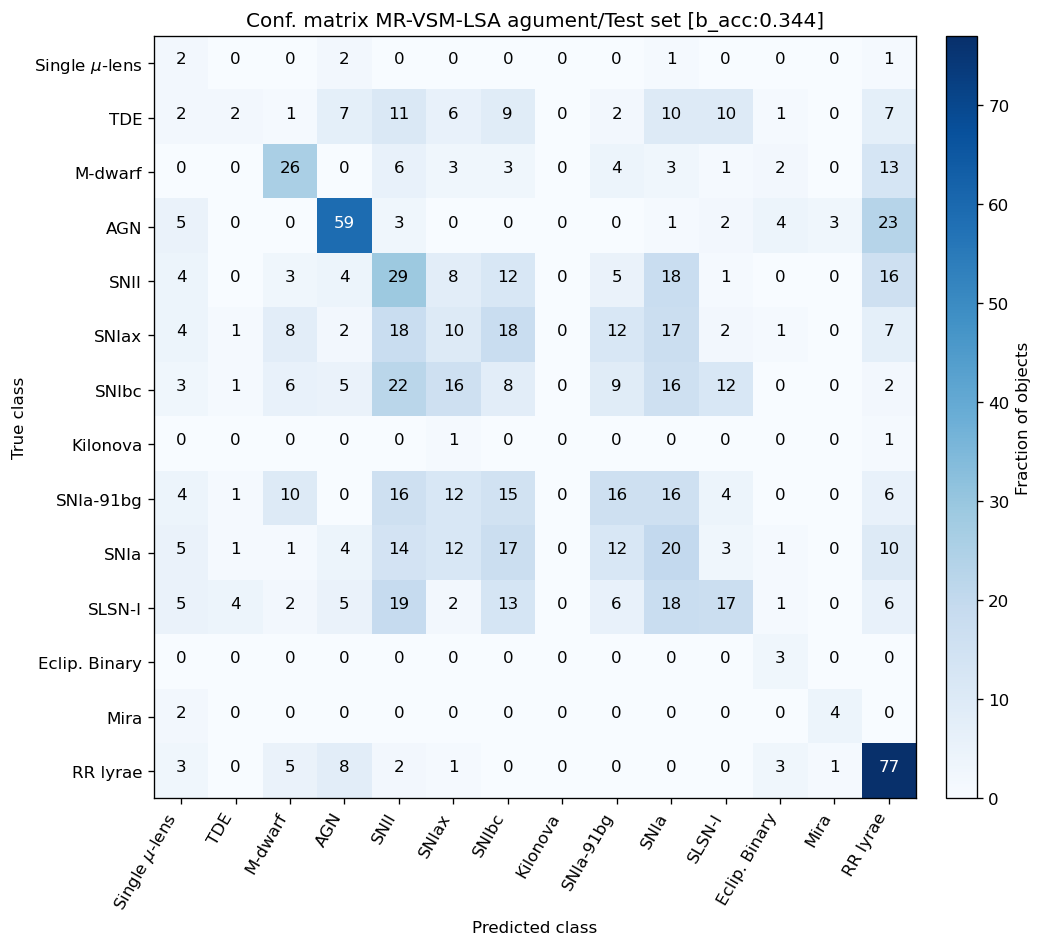

In [46]:
plot_labels_extra_short = {
    6: 'Single $\mu$-lens',
    15: 'TDE',
    16: 'Eclip. Binary',
    42: 'SNII',
    52: 'SNIax',
    53: 'Mira',
    62: 'SNIbc',
    64: 'Kilonova',
    65: 'M-dwarf',
    67: 'SNIa-91bg',
    88: 'AGN',
    90: 'SNIa',
    92: 'RR lyrae',
    95: 'SLSN-I',
    99: 'Unknown',
    1: 'SN',
}

reorder = [6, 15, 65, 88, 42, 52, 62, 64, 67, 90, 95, 16, 53, 92]
classes_names = [plot_labels_extra_short[x] for x in reorder]
cnf_matrix2 = confusion_matrix(l_test, l_pred, labels=reorder)
fig = plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix2, classes=classes_names, normalize=False,
                          title='Conf. matrix MR-VSM-LSA agument/Test set [b_acc:%.3f]' % balanced_accuracy_score(l_test, l_pred))

Confusion matrix, without normalization


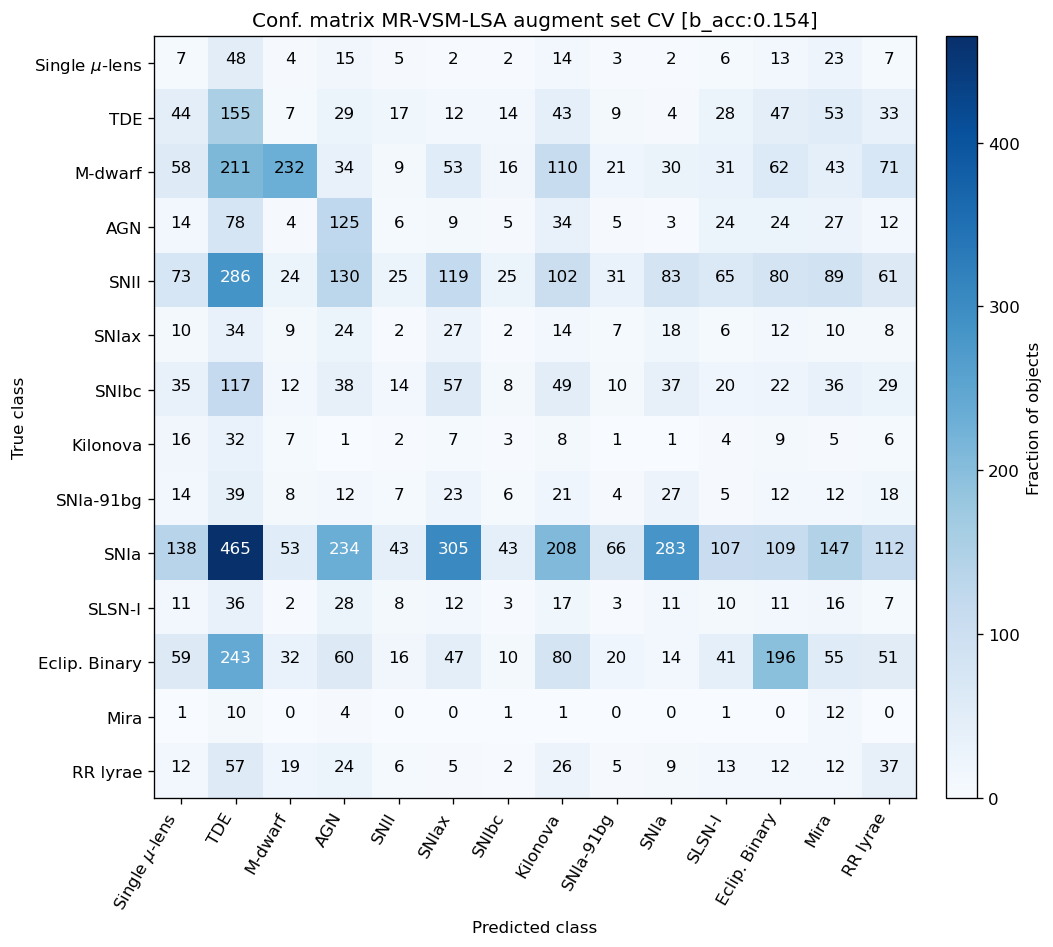

In [26]:
reorder = [6, 15, 65, 88, 42, 52, 62, 64, 67, 90, 95, 16, 53, 92]
classes_names = [plot_labels_extra_short[x] for x in reorder]
cnf_matrix2 = confusion_matrix(l_train, preds, labels=reorder)
fig = plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix2, classes=classes_names, normalize=False,
                          title='Conf. matrix MR-VSM-LSA augment set CV [b_acc:%.3f]' % balanced_accuracy_score(l_train, preds))

Normalized confusion matrix


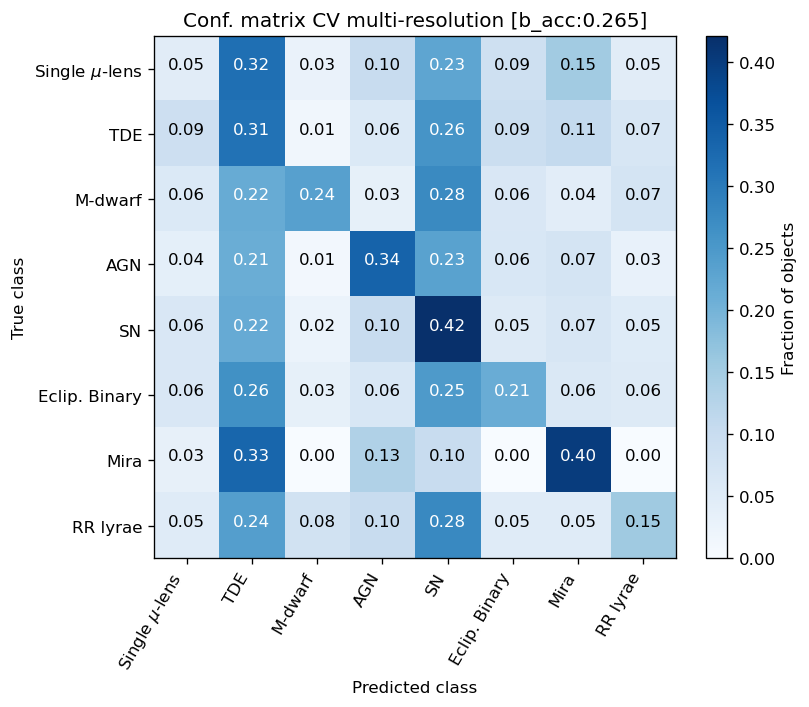

In [27]:
reorder = [6, 15, 65, 88, 1, 16, 53, 92]
classes_names = [plot_labels_extra_short[x] for x in reorder]
lbl_real = np.array([1 if x in [42, 52, 62, 64, 67, 90, 95] else x for x in l_train])
lbl_pred = np.array([1 if x in [42, 52, 62, 64, 67, 90, 95] else x for x in preds])
cnf_matrix2 = confusion_matrix(lbl_real, lbl_pred, labels=reorder)
fig = plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix2, classes=classes_names, normalize=True,
                          title='Conf. matrix CV multi-resolution [b_acc:%.3f]' % balanced_accuracy_score(lbl_real, lbl_pred))

Text(0.5, 1.0, 'explained variance, total sum on 580 components: 0.84')

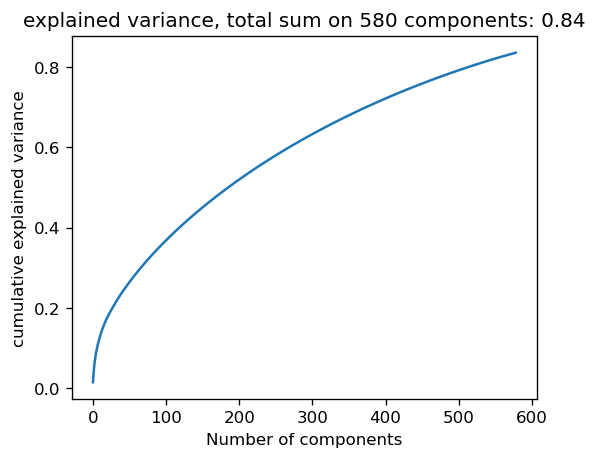

In [174]:
plt.plot(np.cumsum(lsa.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("cumulative explained variance")
plt.title("explained variance, total sum on %d components: %.2f" % (580, np.sum(lsa.explained_variance_ratio_)))

Confusion matrix, without normalization


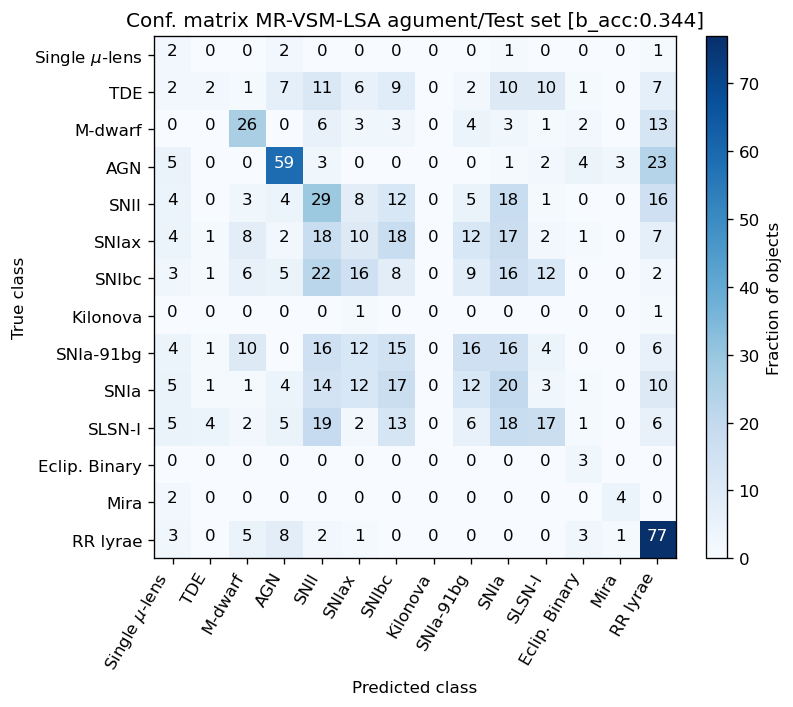

In [52]:
plot_labels_extra_short = {
    6: 'Single $\mu$-lens',
    15: 'TDE',
    16: 'Eclip. Binary',
    42: 'SNII',
    52: 'SNIax',
    53: 'Mira',
    62: 'SNIbc',
    64: 'Kilonova',
    65: 'M-dwarf',
    67: 'SNIa-91bg',
    88: 'AGN',
    90: 'SNIa',
    92: 'RR lyrae',
    95: 'SLSN-I',
    99: 'Unknown',
    1: 'SN',
}

reorder = [6, 15, 65, 88, 42, 52, 62, 64, 67, 90, 95, 16, 53, 92]
classes_names = [plot_labels_extra_short[x] for x in reorder]
cnf_matrix2 = confusion_matrix(l_test, l_pred, labels=reorder)
fig = plt.figure(figsize=(8, 6))
plot_confusion_matrix(cnf_matrix2, classes=classes_names, normalize=False,
                          title='Conf. matrix MR-VSM-LSA agument/Test set [b_acc:%.3f]' % balanced_accuracy_score(l_test, l_pred))